In [1]:
from ibapi.sync_wrapper import *
import pandas as pd
import numpy as np
from pathlib import Path
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output
import akshare as ak
import yfinance as yf
import copy
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [15]:
def bars2ohlcv(bars, day_bar=False):
    df = pd.DataFrame.from_dict([{'date': int(bar.date), 'open': bar.open, 'high': bar.high, 'low': bar.low, 'close': bar.close, 'volume': bar.volume} for bar in bars])
    if day_bar:
        df['date'] = pd.to_datetime(df['date'].astype(str), format='%Y%m%d')
    else:
        df['date'] = pd.to_datetime(df['date'], unit='s', utc=True)
    df.set_index('date', inplace=True)
    return df

def choice2ohlcv(dfr):
  dfr['交易时间'] = dfr['交易时间'].dt.tz_localize('Asia/Shanghai')
  dfr['UTC时间'] = dfr['交易时间'].dt.tz_convert('UTC')
  dfr.set_index('UTC时间', inplace=True)
  dfr.index.name = 'date'
  if '成交量' not in dfr.columns:
    dfr['成交量'] = 0
  dfr = dfr.rename(columns={'开盘价': 'open', '最高价': 'high', '最低价': 'low', '收盘价': 'close', '成交量': 'volume'})
  dfr = dfr[['open', 'high', 'low', 'close', 'volume']]
  return dfr.sort_index(ascending=True)

def yf2ohlcv(dfr, day_bar=False):
  label = dfr.columns.get_level_values(1).unique()[0]
  df = dfr.xs(label, axis=1, level=1)
  df.columns = ['close', 'high', 'low', 'open', 'volume']
  if day_bar:
    df.index = pd.to_datetime(df.index)
  else:
    df.index = pd.to_datetime(df.index, utc=True)
  df.index.name = 'date'
  df = df[['open', 'high', 'low', 'close', 'volume']]
  return df.sort_index(ascending=True)

def akshare2ohlcv(dfr):
  dfr['date'] = pd.to_datetime(dfr['datetime'])
  dfr['date'] = dfr['date'].dt.tz_localize('Asia/Shanghai').dt.tz_convert('UTC')
  dfr.set_index('date', inplace=True)
  return dfr[['open', 'high', 'low', 'close', 'volume']]

def merge_df(df1, df2, df3):
    merged_df = pd.merge(df1, df2, left_index=True, right_index=True, how='inner', suffixes=('_1', '_2'))
    merged_df = pd.merge(merged_df, df3, left_index=True, right_index=True, how='inner')
    merged_df.rename(columns={'close_1': 'a0', 'close_2': 'b0', 'close': 'c0'}, inplace=True)
    merged_df = merged_df[(merged_df['volume_1'] > 0) & (merged_df['volume_2'] > 0)]
    return merged_df[['a0', 'b0', 'c0']]

def merge_asof(df1, df2, df3):
    df1.dropna(inplace=True)
    df2.dropna(inplace=True)
    df3.dropna(inplace=True)

    merged_df = pd.merge_asof(df1.sort_index(), df2.sort_index(), left_index=True, right_index=True, direction='nearest', tolerance=pd.Timedelta('1 hours'), suffixes=('_1', '_2'))
    merged_df = pd.merge_asof(merged_df.sort_index(), df3.sort_index(), left_index=True, right_index=True, direction='nearest', tolerance=pd.Timedelta('1 hours'))
    merged_df.rename(columns={'close_1': 'a0', 'close_2': 'b0', 'close': 'c0'}, inplace=True)
    merged_df = merged_df[(merged_df['volume_1'] > 0) & (merged_df['volume_2'] > 0)]
    return merged_df[['a0', 'b0', 'c0']]

def _build_end_date_time(contract):
    """Return formatted end-date-time string if contract has expired, else empty string."""
    if not contract.lastTradeDateOrContractMonth:
        return ""
    # convert YYYYMM to the last calendar day of that month
    contract_end = pd.to_datetime(contract.lastTradeDateOrContractMonth, format="%Y%m") + pd.offsets.MonthEnd(0)
    now = pd.Timestamp.now(tz=None)
    if contract_end <= now:
        return contract_end.strftime("%Y%m%d-%H:%M:%S")
    return ""

def _build_subsymbol(contract):
    if contract.secType == 'FUT':
        return f'-{contract.lastTradeDateOrContractMonth}'
    elif contract.secType == 'CONTFUT':
        return '-CONTFUT'
    return ''

def get_historical_data(contract, duration, bar_size, up_to_date=True):
    use_rth = contract.secType == 'STK'
    what_to_show = 'MIDPOINT' if contract.exchange == 'IDEALPRO' or contract.secType == 'CMDTY' else 'TRADES'
    subsymbol = _build_subsymbol(contract)
    end_date_time = _build_end_date_time(contract)

    symbol = contract.symbol if contract.exchange != 'IDEALPRO' else f'{contract.symbol}{contract.currency}'
    filepath = f'data/ibkr/{symbol}{subsymbol}-{bar_size.replace(" ", "")}-{what_to_show}.csv'
    path = Path(filepath)
    if path.exists():
        dfe = pd.read_csv(filepath, index_col='date', parse_dates=True)
        now = pd.Timestamp.now(tz=dfe.index.tz)
        _duration = (now - dfe.index[0]).days
        if _duration < duration:
            days = duration
        else:
            days = (now - dfe.index[-1]).days + 1
    else:
        days = duration
        dfe = pd.DataFrame()
    
    # 不需要更新直接返回已有的数据
    if not up_to_date:
        return dfe
    
    #过期合约只需要下载一次
    if is_expired_contract(contract):
        if not dfe.empty:
            return dfe
        else:
            days = 720

    day_bar = bar_size.endswith('day')
    dfn = bars2ohlcv(app.get_historical_data(
        contract=contract, 
        end_date_time=end_date_time, 
        duration_str=days2duration(days),
        bar_size_setting=bar_size,
        what_to_show=what_to_show, 
        use_rth=use_rth,
        format_date=2,
        timeout=24*60*60), day_bar)

    df = pd.concat([dfe, dfn])
    df = df[~df.index.duplicated(keep='first')]
    df = df.sort_index()
    df.to_csv(filepath)
    return df

def days2duration(days):
    if days >= 365:
        years = math.ceil(days / 365)
        return f"{years} Y"
    elif days >= 30:
        months = math.ceil(days / 30)
        return f"{months} M"
    else:
        return f"{days} D"

def get_historical_data_akshare(symbol, bar_size, dfn_fn, up_to_date=True):
    def provider():
        return f'data/akshare/{dfn_fn.__name__}-{symbol}-{bar_size}mins.csv'
    return get_historical_data_from_provider(provider, symbol, bar_size, dfn_fn, up_to_date)

def get_historical_data_yfinance(symbol, bar_size, dfn_fn, up_to_date=True):
    def provider():
        return f'data/yfinance/{dfn_fn.__name__}-{symbol}-{bar_size}.csv'
    return get_historical_data_from_provider(provider, symbol, bar_size, dfn_fn, up_to_date)

def get_historical_data_from_provider(provider_fn, symbol, bar_size, dfn_fn, up_to_date=True):
    filepath = provider_fn()
    path = Path(filepath)
    if path.exists():
        dfe = pd.read_csv(filepath, index_col='date', parse_dates=True)
    else:
        dfe = pd.DataFrame()

    if not up_to_date:
        return dfe
    
    dfn = dfn_fn(symbol, bar_size)

    df = pd.concat([dfe, dfn])
    df = df[~df.index.duplicated(keep='first')]
    df = df.sort_index()
    df.to_csv(filepath)
    return df

def is_expired_contract(contract):
    if contract.secType != 'FUT':
        return False
    if contract.lastTradeDateOrContractMonth is None:
        return False
    now = datetime.now()
    year = now.year
    month = now.month
    return int(contract.lastTradeDateOrContractMonth) < year * 100 + month

def futures_zh_minute_sina(symbol, bar_size):
    return akshare2ohlcv(ak.futures_zh_minute_sina(symbol=symbol, period=bar_size))

def futures_hist_em(symbol, bar_size):
    df = ak.futures_hist_em(symbol=symbol, period=bar_size)
    df['date'] = pd.to_datetime(df['时间'])
    df.set_index('date', inplace=True)
    df = df.rename(columns={'开盘': 'open', '最高': 'high', '最低': 'low', '收盘': 'close', '成交量': 'volume'})
    return df[['open', 'high', 'low', 'close', 'volume']]

def yf_hist(symbol, bar_size):
    yf.config.network.proxy = {
        "http": "http://127.0.0.1:1080",
        "https": "http://127.0.0.1:1080"
    }
    period_map = {
        'm': 'max',
        'h': '730d',
        'd': 'max'
    }
    day_bar = bar_size.endswith('d')
    return yf2ohlcv(yf.download(symbol, period=period_map[bar_size[-1]], interval=bar_size), day_bar)

def get_monthly_future(contract, month):
    mc = copy.deepcopy(contract)
    mc.secType = 'FUT'
    mc.lastTradeDateOrContractMonth = str(month)
    mc.includeExpired = True
    return mc

def build_ibkr_main_future(contract, duration, bar_size, up_to_date=True):
    '''手动拼接主力合约，只更新当月的合约数据，合约变换时，需要指定新合约'''
    now = datetime.now()
    end_date = now + relativedelta(months=5)
    min_start_date = now - relativedelta(months=23)
    start_date = now - timedelta(days=duration) - relativedelta(years=1)
    start_date = max(min_start_date, start_date)
    months_diff = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month) + 1
    month_list = [(start_date + relativedelta(months=i)).strftime("%Y%m") for i in range(months_diff)]
    df_list = [get_historical_data(get_monthly_future(contract, month), duration, bar_size, up_to_date) for month in month_list]

    df_all = pd.concat(df_list)
    df = (df_all
        .reset_index()
        .loc[
            lambda x: x.groupby('date')['volume'].idxmax()
        ]
        .set_index('date')
        .sort_index()
    )

    return df

In [8]:
app = TWSSyncWrapper(timeout=24 * 60 * 60)
app.connect_and_start(host="127.0.0.1", port=7496, client_id=1)
app.get_current_time()

# app.disconnect_and_stop()

1767175886

ERROR -1 0 2104 Market data farm connection is OK:hfarm
ERROR -1 0 2104 Market data farm connection is OK:usfuture
ERROR -1 0 2104 Market data farm connection is OK:cashfarm
ERROR -1 0 2104 Market data farm connection is OK:usfarm
ERROR -1 0 2106 HMDS data farm connection is OK:euhmds
ERROR -1 0 2106 HMDS data farm connection is OK:apachmds
ERROR -1 0 2106 HMDS data farm connection is OK:cashhmds
ERROR -1 0 2106 HMDS data farm connection is OK:fundfarm
ERROR -1 0 2106 HMDS data farm connection is OK:ushmds
ERROR -1 0 2158 Sec-def data farm connection is OK:secdefhk


In [11]:
USDJPY = Contract()
USDJPY.symbol = "USD"
USDJPY.secType = "CASH"
USDJPY.exchange = "IDEALPRO"
USDJPY.currency = "JPY"

USDCNH = Contract()
USDCNH.symbol = "USD"
USDCNH.secType = "CASH"
USDCNH.exchange = "IDEALPRO"
USDCNH.currency = "CNH"

GD = Contract()
GD.symbol = "GOLD"
GD.secType = "CONTFUT"
GD.exchange = "OSE.JPN"
GD.currency = "JPY"

M_PT = Contract()
M_PT.symbol = "M-PT"
M_PT.secType = "CONTFUT"
M_PT.exchange = "OSE.JPN"
M_PT.currency = "JPY"

PLAT = Contract()
PLAT.symbol = "PLAT"
PLAT.secType = "CONTFUT"
PLAT.exchange = "OSE.JPN"
PLAT.currency = "JPY"

GC = Contract()
GC.symbol = "GC"
GC.secType = "CONTFUT"
GC.exchange = "COMEX"
GC.currency = "USD"

MGC = Contract()
MGC.symbol = "MGC"
MGC.secType = "CONTFUT"
MGC.exchange = "COMEX"
MGC.currency = "USD"

_1OZ = Contract()
_1OZ.symbol = "1OZ"
_1OZ.secType = "CONTFUT"
_1OZ.exchange = "COMEX"
_1OZ.currency = "USD"

XAUUSD = Contract()
XAUUSD.symbol = "XAUUSD"
XAUUSD.secType = "CMDTY"
XAUUSD.exchange = "SMART"
XAUUSD.currency = "USD"

XAGUSD = Contract()
XAGUSD.symbol = "XAGUSD"
XAGUSD.secType = "CMDTY"
XAGUSD.exchange = "SMART"
XAGUSD.currency = "USD"

SI = Contract()
SI.symbol = "SI"
SI.secType = "CONTFUT"
SI.exchange = "COMEX"
SI.currency = "USD"
SI.multiplier = "5000"

PL = Contract()
PL.symbol = "PL"
PL.secType = "CONTFUT"
PL.exchange = "NYMEX"
PL.currency = "USD"

PPLT = Contract()
PPLT.symbol = "PPLT"
PPLT.secType = "STK"
PPLT.exchange = "SMART"
PPLT.currency = "USD"

In [23]:
# df = get_historical_data(get_monthly_future(GC, '202602'), 720, '1 hour', up_to_date=True)


In [24]:
# df['a-b'] = np.log(df['close_2']) - np.log(df['close_1'])

# df1 = choice2ohlcv(pd.read_excel('C:\\Users\\wayne\\Desktop\\kline\\基准\\AG0\\K线导出_AG0_60分钟线数据-251227.xlsx'))

In [34]:
# Comex 黄金、XAUUSD

# 分钟级别
# df1 = get_historical_data(_1OZ, 15, '1 min', up_to_date=True)
# df2 = get_historical_data(MGC, 15, '1 min', up_to_date=True)

# 小时级别
df1 = build_ibkr_main_future(GC, 720, '1 hour', up_to_date=False)
# # df1 = get_historical_data(GC, 720, '1 hour', up_to_date=False)
df2 = get_historical_data(XAUUSD, 720, '1 hour', up_to_date=False)

df= pd.merge(df1, df2, on='date', how='inner')
# df = df[(df['volume_x'] > 0) & (df['volume_y'] > 0)]
df['a'] = df['close_x']
df['b'] = df['close_y']
df['a-b'] = df['a'] - df['b']

In [26]:
# Comex 白银、XAGUSD

# 分钟级别
# df1 = get_historical_data(_1OZ, 15, '1 min', up_to_date=True)
# df2 = get_historical_data(MGC, 15, '1 min', up_to_date=True)

# 小时级别
df1 = build_ibkr_main_future(SI, 720, '1 hour', up_to_date=True)
# df1 = get_historical_data(SI, 720, '1 hour', up_to_date=True)
df2 = get_historical_data(XAGUSD, 720, '1 hour', up_to_date=False)

df= pd.merge(df1, df2, on='date', how='inner')
# df = df[(df['volume_x'] > 0) & (df['volume_y'] > 0)]
df['a'] = df['close_x']
df['b'] = df['close_y']
df['a-b'] = df['a'] - df['b']

In [27]:
# 大阪黄金 - Comex 黄金

# 120 分钟级别
# df1 = get_historical_data(GD, 720, '1 hour', up_to_date=True)
# df2 = get_historical_data(GC, 720, '1 hour', up_to_date=True)
# df3 = get_historical_data(USDJPY, 720, '1 hour', up_to_date=True)
# df= merge_asof(df1, df2, df3)


# df['a'] = df['a0'] / df['c0'] * 31.1034768
# df['b'] = df['b0'] 
# df['a-b'] = df['a'] - df['b']

In [12]:
# 沪金 - Comex 黄金

# 60 分钟级别 - ibkr 数据
df1 = choice2ohlcv(pd.read_excel('data/choice/K线导出_AU0_60分钟线数据.xlsx'))
df2 = build_ibkr_main_future(GC, 720, '1 hour', up_to_date=False)
df3 = get_historical_data(USDCNH, 720, '1 hour', up_to_date=True)
df= merge_asof(df1, df2, df3)

df['a'] = df['a0'] 
df['b'] = df['b0'] * df['c0'] / 31.1034768
df['a-b'] = df['a'] - df['b']

In [39]:
# 沪银 - Comex 白银

# 分钟级别
# df1 = choice2ohlcv(pd.read_excel('data/choice/K线导出_AG0_5分钟线数据.xlsx'))
# df1 = get_historical_data_akshare("AG0", "5", futures_zh_minute_sina, up_to_date=True)
# df2 = get_historical_data(SI, 7, '5 mins', up_to_date=True)
# df3 = get_historical_data(USDCNH, 7, '5 mins', up_to_date=True)
# df = merge_df(df1, df2, df3)

# 120 分钟级别 - ibkr 数据
df1 = choice2ohlcv(pd.read_excel('data/choice/K线导出_AG0_120分钟线数据.xlsx'))
df2 = build_ibkr_main_future(SI, 720, '1 hour', up_to_date=False)
df3 = get_historical_data(USDCNH, 720, '2 hours', up_to_date=False)
df= merge_asof(df1, df2, df3)

# 120 分钟级别 - yf 数据，与 ibkr 相比，向上平移 200 左右
# df1 = choice2ohlcv(pd.read_excel('C:\\Users\\wayne\\Desktop\\kline\\基准\\AG0\\K线导出_AG0_120分钟线数据.xlsx'))
# df2 = get_historical_data_yfinance('SI=F', '1h', yf_hist, up_to_date=True)
# df3 = get_historical_data(USDCNH, 720, '2 hours', up_to_date=False)
# df= merge_asof(df1, df2, df3)

# 日线级别
# df1 = get_historical_data_akshare("沪银主连", "daily", futures_hist_em, up_to_date=False)
# df2 = get_historical_data_yfinance('SI=F', '1d', yf_hist, up_to_date=False)
# df3 = get_historical_data(USDCNH, 7200, '1 day', up_to_date=False)
# df = merge_df(df1, df2, df3)

df['a'] = df['a0'] 
df['b'] = df['b0'] * df['c0'] * 1000 / 31.1034768
df['a-b'] = df['a'] - df['b']

In [13]:
lower, upper = df['a-b'].quantile([0.025, 0.975])
print(f'relation: {df["a"].corr(df["b"])}')
print(f'95%: {lower:.4f}, {upper:.4f}')
print(f'N ({df["a-b"].mean():.4f}, {df["a-b"].std():.4f})')

# df['MA20'] = df['a-b'].rolling(20).mean()
# df['MA114'] = df['a-b'].rolling(114).mean()
# df['EMA114'] = df['a-b'].ewm(span=114, adjust=False).mean()


relation: 0.9985984959496027
95%: -13.2162, 11.6899
N (-2.0093, 6.1414)


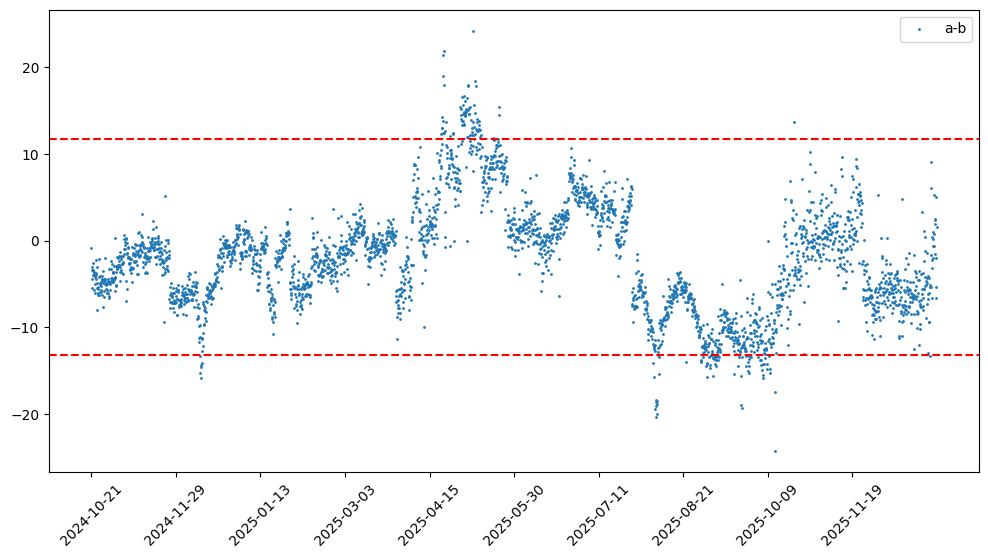

In [14]:
plt.figure(figsize=(12, 6))

x = range(len(df.index))

# plt.plot(x, df['a'], label='a')
# plt.plot(x, df['b'], label='b')
# plt.plot(x, df['MA114'], label='ma')
# plt.plot(x, df['EMA114'], label='ema')
plt.scatter(x, df['a-b'], s=1, label='a-b')

step = max(1, len(x) // 10)
ticks = x[::step]
labels = df.index.strftime('%Y-%m-%d')[::step]

plt.xticks(ticks, labels, rotation=45)

plt.axhline(y=lower, color='r', linestyle='--')
plt.axhline(y=upper, color='r', linestyle='--')

plt.legend()
plt.show()

In [ ]:
# df[(df['a-b'] < -10) | (df['a-b'] > 10)]
# df1[(df1.index.hour==23) & (df1.index.minute==0) & (df1['high'] - df1['low'] > 10)]


ERROR -1 0 2105 HMDS data farm connection is broken:euhmds
ERROR -1 0 1100 Connectivity between IBKR and Trader Workstation has been lost.
ERROR -1 0 2105 HMDS data farm connection is broken:fundfarm
ERROR -1 0 2106 HMDS data farm connection is OK:euhmds
ERROR -1 0 2105 HMDS data farm connection is broken:euhmds
ERROR -1 0 2157 Sec-def data farm connection is broken:secdefhk
ERROR -1 0 2103 Market data farm connection is broken:cashfarm
ERROR -1 0 2103 Market data farm connection is broken:hfarm
ERROR -1 0 2103 Market data farm connection is broken:usfuture
ERROR -1 0 2103 Market data farm connection is broken:usfarm
ERROR -1 0 2105 HMDS data farm connection is broken:apachmds
ERROR -1 0 2105 HMDS data farm connection is broken:ushmds
ERROR -1 0 2105 HMDS data farm connection is broken:cashhmds
ERROR -1 0 2158 Sec-def data farm connection is OK:secdefhk
ERROR -1 0 2106 HMDS data farm connection is OK:apachmds
ERROR -1 0 2104 Market data farm connection is OK:hfarm
ERROR -1 0 2106 HMDS 